# All the libraries are imported in following block. Initial load, we have to ensure that the following nltk are downloaded.

# Download necessary NLTK resources (only needed once)
 nltk.download('punkt')       # Standard tokenizer resource
 nltk.download('punkt_tab')   # Additional resource required by some tokenizers
 nltk.download('stopwords')
 nltk.download('wordnet')

In [1]:
# Import necessary libraries and download NLTK resources
import os
import re
import string
import pandas as pd
import numpy as np
import nltk
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from wordcloud import WordCloud
from transformers import pipeline
from textblob import TextBlob
import flair

# Ensure necessary NLTK data is available
# nltk.download('vader_lexicon')

# Download necessary NLTK resources (only needed once)
# nltk.download('punkt')       # Standard tokenizer resource
# nltk.download('punkt_tab')   # Additional resource required by some tokenizers
# nltk.download('stopwords')
# nltk.download('wordnet')

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import Counter
from wordcloud import WordCloud

# Scikit-learn imports for vectorization, modeling, and evaluation

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

Section B: Data analysis, selection, and labeling

Analyzing the data extracted.

In [2]:
# Load the dataset from Excel
file_path = "../Data/processed/Final_Noon_Datasets.csv"  # Update with actual file path

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found at {csv_file_path}. Please check the path.")

# Load the CSV file into a Pandas DataFrame
try:
    df = pd.read_csv(file_path)
except Exception as e:
    raise Exception(f"Error loading CSV file: {e}")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indicating that ...      1   

           created_utc  is_submitter  contains_no

In [3]:
# Display basic information about the dataset
print("Dataset Overview:\n")
print(df.info())

Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   post_id                3598 non-null   object
 1   post_title             3598 non-null   object
 2   comment_id             3598 non-null   object
 3   author                 3360 non-null   object
 4   comment_text           3598 non-null   object
 5   score                  3598 non-null   int64 
 6   created_utc            3598 non-null   object
 7   is_submitter           3598 non-null   bool  
 8   contains_noon_mention  3598 non-null   bool  
 9   type                   3598 non-null   object
 10  subreddit              3079 non-null   object
dtypes: bool(2), int64(1), object(8)
memory usage: 260.1+ KB
None


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:\n")
print(missing_values)


Missing Values Per Column:

post_id                    0
post_title                 0
comment_id                 0
author                   238
comment_text               0
score                      0
created_utc                0
is_submitter               0
contains_noon_mention      0
type                       0
subreddit                519
dtype: int64


In [5]:
# Check for non-null values
non_null_counts = df.notnull().sum()
print("\nNon-null Values Per Column:\n")
print(non_null_counts)




Non-null Values Per Column:

post_id                  3598
post_title               3598
comment_id               3598
author                   3360
comment_text             3598
score                    3598
created_utc              3598
is_submitter             3598
contains_noon_mention    3598
type                     3598
subreddit                3079
dtype: int64


In [6]:
# Check data types
data_types = df.dtypes
print("\nData Types of Each Column:\n")
print(data_types)




Data Types of Each Column:

post_id                  object
post_title               object
comment_id               object
author                   object
comment_text             object
score                     int64
created_utc              object
is_submitter               bool
contains_noon_mention      bool
type                     object
subreddit                object
dtype: object


In [7]:
# Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:\n")
print(df.describe())


Summary Statistics for Numerical Columns:

             score
count  3598.000000
mean      4.115064
std      11.254040
min     -26.000000
25%       1.000000
50%       2.000000
75%       3.000000
max     298.000000


In [8]:
# Summary statistics for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nSummary Statistics for Categorical Columns:\n")
print(df[categorical_columns].describe())
print("\nData Analysis Complete.")



Summary Statistics for Categorical Columns:

       post_id                post_title comment_id         author  \
count     3598                      3598       3598           3360   
unique     821                       805       3598           1986   
top     w16tc7  Lost AED 8,000+ to noon.    m9mjkdv  startuphameed   
freq        63                        63          1             41   

       comment_text          created_utc     type subreddit  
count          3598                 3598     3598      3079  
unique         3572                 3598        1         9  
top            Noon  2025-01-28 16:33:14  comment     dubai  
freq             12                    1     3598      2012  

Data Analysis Complete.


# Section B: Data analysis, selection, and labeling

## Adding Vader Lexicon, Flair and TextBlob sentiment score to get the exact value of the sentiment.

### There are three columns added to rate the positive, negative or neutral sentiments. 
### Sentiment_VADER, Sentiment_TextBlob & Sentiment_Flair


## Adding final column on a consolidated sentiment rating which is a 5 pointer based system as mentioned below.
	•	5 → All three sentiments are Positive
	•	4 → Two sentiments are Positive
	•	3 → All three are Neutral or two are Neutral
	•	2 → Two sentiments are Negative
	•	1 → All three sentiments are Negative

In [9]:

# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
classifier = pipeline("sentiment-analysis")
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customizing VADER's lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

# Function to get sentiment using VADER with enhanced lexicon
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

# Function to get sentiment using Flair
def get_flair_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':  # Positive sentiment
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':  # Negative sentiment
            sentiment_scores["Negative"] += 1
        else:  # Neutral sentiment
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Function to apply Longformer with a sliding window (handles text > 512 tokens)
def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = longformer_classifier(chunk)[0]  # Get model output

        # Retrieve model-generated label dynamically
        label = result['label']

        if "pos" in label.lower():  # Matches positive sentiment labels
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():  # Matches negative sentiment labels
            sentiment_scores["Negative"] += 1
        else:  # Assume any other label is neutral
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Rule-based sentiment adjustment
def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if neg_count > pos_count:
        return "Negative"
    elif pos_count > neg_count:
        return "Positive"
    else:
        return "Neutral"

print("\nStarted the sentiment analysis\n")

# Apply sentiment analysis to the comment_text column
df['Sentiment_VADER'] = df['comment_text'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['comment_text'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['comment_text'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['comment_text'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['comment_text'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['comment_text'].apply(get_adjusted_sentiment)

# Function to calculate the final 5-point rating
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 4:
        return 5
    elif positive_count == 3:
        return 4
    elif negative_count == 3:
        return 2
    elif negative_count >= 4:
        return 1
    else:
        return 3

# Apply the rating calculation
df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)

print(f"Sentiment analysis complete. Results saved")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


Started the sentiment analysis

Sentiment analysis complete. Results saved

First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indi


Sentiment Rating Distribution:
Sentiment_Rating
1     526
2     543
3    1657
4     499
5     373
Name: count, dtype: int64


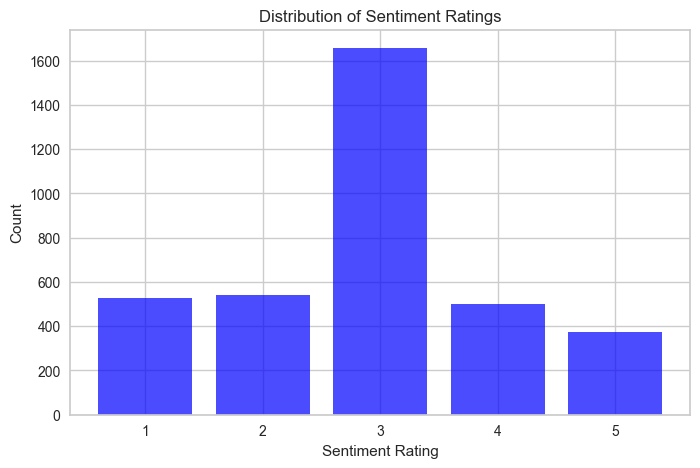


Most Common Words in Comments with Rating 5:
[('.', 961), ('the', 549), (',', 508), ('and', 457), ('I', 454), ('a', 311), ('to', 295), ('noon', 292), ('is', 281), ('it', 273)]

Most Common Words in Comments with Rating 4:
[('.', 1367), ('the', 787), (',', 709), ('and', 628), ('I', 586), ('to', 529), ('noon', 430), ('a', 416), ('it', 394), ('is', 370)]

Most Common Words in Comments with Rating 3:
[('.', 2898), ('the', 1777), (',', 1488), ('noon', 1174), ('and', 1140), ('I', 1137), ('to', 1103), ('a', 1003), ('it', 915), ('is', 810)]

Most Common Words in Comments with Rating 2:
[('.', 1481), ('the', 976), (',', 788), ('I', 665), ('and', 640), ('to', 629), ('a', 617), ('noon', 458), ('it', 455), ('is', 388)]

Most Common Words in Comments with Rating 1:
[('.', 1470), ('the', 928), ('and', 736), ('I', 734), (',', 697), ('to', 679), ('a', 627), ('it', 464), ('is', 397), ('noon', 396)]


In [10]:
# Analysis of Sentiment Ratings
rating_counts = df['Sentiment_Rating'].value_counts().sort_index()
print("\nSentiment Rating Distribution:")
print(rating_counts)

# Plot sentiment rating distribution
plt.figure(figsize=(8,5))
plt.bar(rating_counts.index, rating_counts.values, color='blue', alpha=0.7)
plt.xlabel("Sentiment Rating")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Ratings")
plt.show()

# Further Text Analytics on Ratings
for rating in [5, 4, 3, 2, 1]:
    print(f"\nMost Common Words in Comments with Rating {rating}:")
    rating_text = " ".join(df[df['Sentiment_Rating'] == rating]['comment_text'].dropna())
    words = nltk.FreqDist(nltk.word_tokenize(rating_text))
    print(words.most_common(10))

In [11]:
# Save the results to an Excel file
output_path = "Final_Noon_Datasets_with_Sentiments.xlsx"
df.to_excel(output_path, index=False)

# Preprocessing Noon Company Reviews (Extracted from Reddit)

Preprocessing is a critical step in Natural Language Processing (NLP) tasks, especially for sentiment analysis. Raw reviews from social media platforms like Reddit contain noise, irrelevant words, and inconsistencies that can reduce the accuracy of sentiment classification.

## Why is Preprocessing Important?
- Reddit comments contain informal language (slang, emojis, abbreviations, etc.)
- Reviews may have unnecessary elements (punctuation, special characters, URLs)
- Noisy text reduces sentiment model performance
- Proper normalization ensures better consistency across comments

## Steps in Preprocessing Reddit Reviews on Noon

### 1. Letter Casing (Convert all text to lowercase)
- Reviews may contain mixed case text (e.g., "Great service" vs "GREAT SERVICE")
- Converting all text to lowercase ensures uniformity.

### 2. Tokenization (Breaking text into words/tokens)
- Example review:
  ```
  "Noon’s service was great! I loved it."
  ```
  Becomes:
  ```
  ['noon', 'service', 'was', 'great', 'i', 'loved', 'it']
  ```
- Tokenization allows word-level analysis.

### 3. Noise Removal (Eliminating unwanted characters)
- Remove:
  - HTML tags
  - Punctuation (?, !, ...)
  - Special characters (@, #, $)
  - Extra whitespace
  - URLs (https://noon.com)

### 4. Stopword Removal (Eliminating non-informative words)
- Words like "is", "the", "and", "it" do not impact sentiment.
- Removing stopwords reduces noise and focuses on meaningful words.
- Example:
  ```
  "The customer support was really bad."
  ```
  Transforms to:
  ```
  "customer support bad"
  ```

### 5. Normalization (Converting words to a standard format)
- Fix inconsistencies in text:
  - "gr8" → "great"
  - "u" → "you"
  - "iPhone 15 pro" → "iphone 15 pro"
- Convert informal text to proper English.

### 6. Stemming & Lemmatization (Reducing words to root form)
- **Stemming** removes suffixes, but may distort words:
  - "returning" → "return"
  - "customers" → "custom"
- **Lemmatization** provides a more accurate base form:
  - "better" → "good"
  - "worse" → "bad"
  - "running" → "run"

For Noon’s reviews, **lemmatization is preferred** to retain the original meaning.

---

In [13]:
# Function to convert text to lowercase
def to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    if "<" in text and ">" in text:  
        return BeautifulSoup(text, "html.parser").get_text()
    return text  

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)  # Remove links

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove special characters
def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function to tokenize text
def tokenize(text):
    return word_tokenize(text)

# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Function to convert emojis to text
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

# Function to perform lemmatization
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_emojis(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return " ".join(tokens)

# Apply preprocessing to the comment_text column
df['processed_comment'] = df['comment_text'].apply(preprocess_text)

# Save the preprocessed data
output_path = "Final_Noon_Datasets_Preprocessed.xlsx"
df.to_excel(output_path, index=False)

print(f"Preprocessing complete. Results saved to {output_path}")

# Display first few rows of preprocessed data
print(df[['comment_text', 'processed_comment']].head())


Preprocessing complete. Results saved to Final_Noon_Datasets_Preprocessed.xlsx
                                        comment_text  \
0                          will reach border by noon   
1  Be careful of blowing dust during late morning...   
2  Apart from boring things, you can managed. How...   
3  You are looking at a tag in noon app saying 1 ...   
4  Are you sure? There's nothing indicating that ...   

                                   processed_comment  
0                                  reach border noon  
1  careful blowing dust late morning noon sand he...  
2  apart boring thing managed however light pole ...  
3  looking tag noon app saying 1 year warranty sa...  
4  sure there nothing indicating reading noon war...  


In [14]:
# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indicating that ...      1   

           created_utc  is_submitter  contains_no

In [16]:

# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
classifier = pipeline("sentiment-analysis")
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customizing VADER's lexicon
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

# Function to get sentiment using VADER with enhanced lexicon
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

# Function to get sentiment using Flair
def get_flair_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"

    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)

    # Check if Flair returned any labels
    if not sentence.labels:  # Fix: Check for empty label list
        return "Neutral"

    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        if result['label'] == 'LABEL_2':  # Positive sentiment
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':  # Negative sentiment
            sentiment_scores["Negative"] += 1
        else:  # Neutral sentiment
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Function to apply Longformer with a sliding window (handles text > 512 tokens)
def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"

    # Token splitting: Create overlapping text chunks
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])  # Extract a chunk
        i += max_length - overlap  # Move forward with overlap

    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}

    for chunk in chunks:
        result = longformer_classifier(chunk)[0]  # Get model output

        # Retrieve model-generated label dynamically
        label = result['label']

        if "pos" in label.lower():  # Matches positive sentiment labels
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():  # Matches negative sentiment labels
            sentiment_scores["Negative"] += 1
        else:  # Assume any other label is neutral
            sentiment_scores["Neutral"] += 1

    # Return the majority sentiment
    return max(sentiment_scores, key=sentiment_scores.get)

# Rule-based sentiment adjustment
def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if neg_count > pos_count:
        return "Negative"
    elif pos_count > neg_count:
        return "Positive"
    else:
        return "Neutral"

print("\nStarted the sentiment analysis\n")

# Apply sentiment analysis to the comment_text column
df['Sentiment_VADER'] = df['processed_comment'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['processed_comment'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['processed_comment'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['processed_comment'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['processed_comment'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['processed_comment'].apply(get_adjusted_sentiment)

# Function to calculate the final 5-point rating
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 4:
        return 5
    elif positive_count == 3:
        return 4
    elif negative_count == 3:
        return 2
    elif negative_count >= 4:
        return 1
    else:
        return 3

# Apply the rating calculation
df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)

print(f"Sentiment analysis complete. Results saved")

# Display first few rows
print("\nFirst 5 Rows of the Dataset:\n")
print(df.head())


Started the sentiment analysis

Sentiment analysis complete. Results saved

First 5 Rows of the Dataset:

   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indi


Sentiment Rating Distribution:
Sentiment_Rating
1     483
2     466
3    1911
4     458
5     280
Name: count, dtype: int64


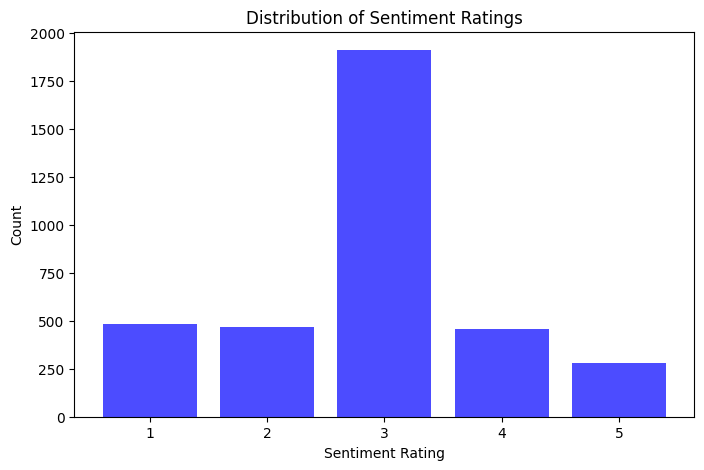


Most Common Words in Comments with Rating 5:
[('noon', 341), ('good', 108), ('amazon', 81), ('bought', 61), ('seller', 54), ('price', 43), ('also', 40), ('delivery', 39), ('got', 38), ('experience', 37)]

Most Common Words in Comments with Rating 4:
[('noon', 631), ('amazon', 220), ('good', 134), ('seller', 119), ('buy', 87), ('also', 87), ('item', 83), ('one', 79), ('bought', 78), ('get', 73)]

Most Common Words in Comments with Rating 3:
[('noon', 2302), ('amazon', 497), ('seller', 358), ('get', 292), ('buy', 290), ('dont', 261), ('one', 232), ('like', 217), ('product', 213), ('item', 201)]

Most Common Words in Comments with Rating 2:
[('noon', 655), ('amazon', 157), ('seller', 112), ('dont', 110), ('item', 102), ('get', 81), ('issue', 79), ('customer', 78), ('time', 73), ('service', 71)]

Most Common Words in Comments with Rating 1:
[('noon', 705), ('amazon', 160), ('customer', 112), ('item', 111), ('issue', 103), ('dont', 103), ('never', 103), ('product', 102), ('fake', 94), ('ev

In [17]:
# Analysis of Sentiment Ratings
rating_counts = df['Sentiment_Rating'].value_counts().sort_index()
print("\nSentiment Rating Distribution:")
print(rating_counts)

# Plot sentiment rating distribution
plt.figure(figsize=(8,5))
plt.bar(rating_counts.index, rating_counts.values, color='blue', alpha=0.7)
plt.xlabel("Sentiment Rating")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Ratings")
plt.show()

# Further Text Analytics on Ratings
for rating in [5, 4, 3, 2, 1]:
    print(f"\nMost Common Words in Comments with Rating {rating}:")
    rating_text = " ".join(df[df['Sentiment_Rating'] == rating]['processed_comment'].dropna())
    words = nltk.FreqDist(nltk.word_tokenize(rating_text))
    print(words.most_common(10))

In [19]:

# Compute character and word counts before and after preprocessing
df['char_count_before'] = df['comment_text'].astype(str).apply(len)
df['char_count_after'] = df['processed_comment'].astype(str).apply(len)
df['word_count_before'] = df['comment_text'].astype(str).apply(lambda x: len(word_tokenize(x)))
df['word_count_after'] = df['processed_comment'].astype(str).apply(lambda x: len(word_tokenize(x)))

# Compute reduction percentages
df['char_reduction'] = ((df['char_count_before'] - df['char_count_after']) / df['char_count_before']) * 100
df['word_reduction'] = ((df['word_count_before'] - df['word_count_after']) / df['word_count_before']) * 100

# Extract word frequency before and after preprocessing
def get_most_common_words(text_column, n=20):
    all_words = " ".join(text_column).split()
    return Counter(all_words).most_common(n)

common_words_before = get_most_common_words(df['comment_text'].dropna())
common_words_after = get_most_common_words(df['processed_comment'].dropna())

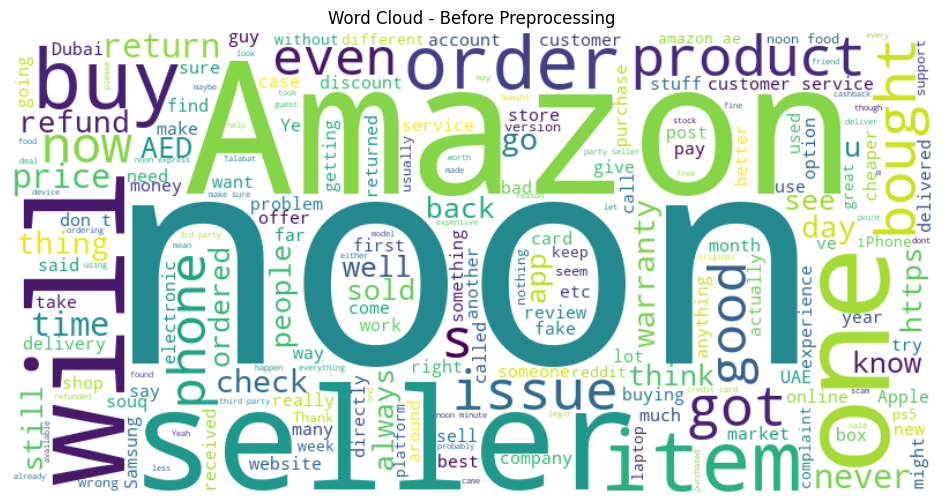

In [22]:

# Word Cloud - Before Preprocessing
plt.figure(figsize=(12,6))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df['comment_text'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Before Preprocessing")
plt.show()

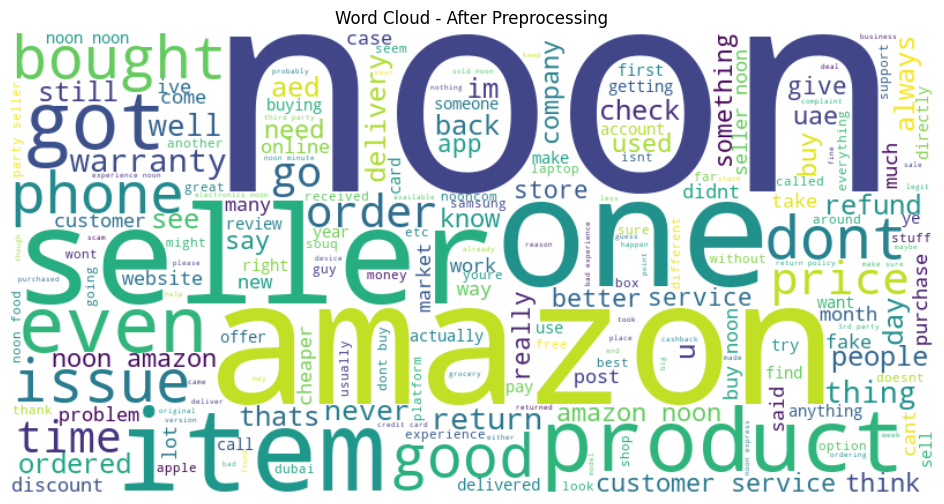

In [23]:
# Word Cloud - After Preprocessing
plt.figure(figsize=(12,6))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df['processed_comment'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - After Preprocessing")
plt.show()


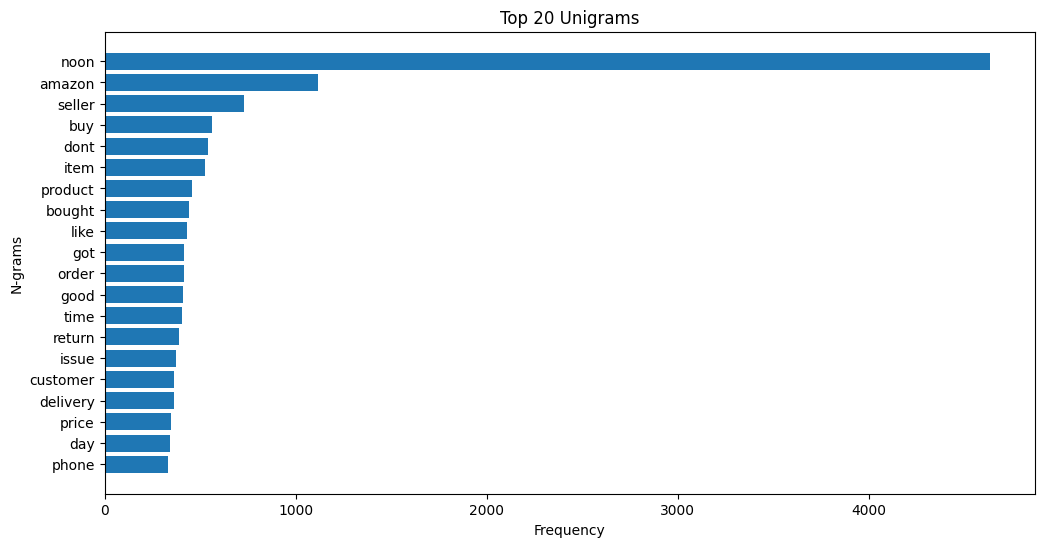

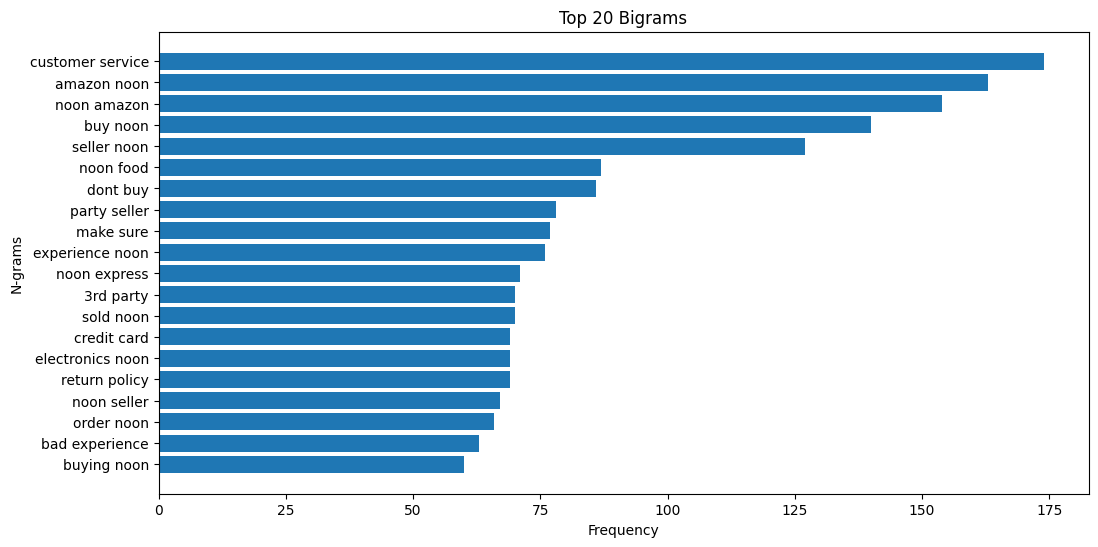

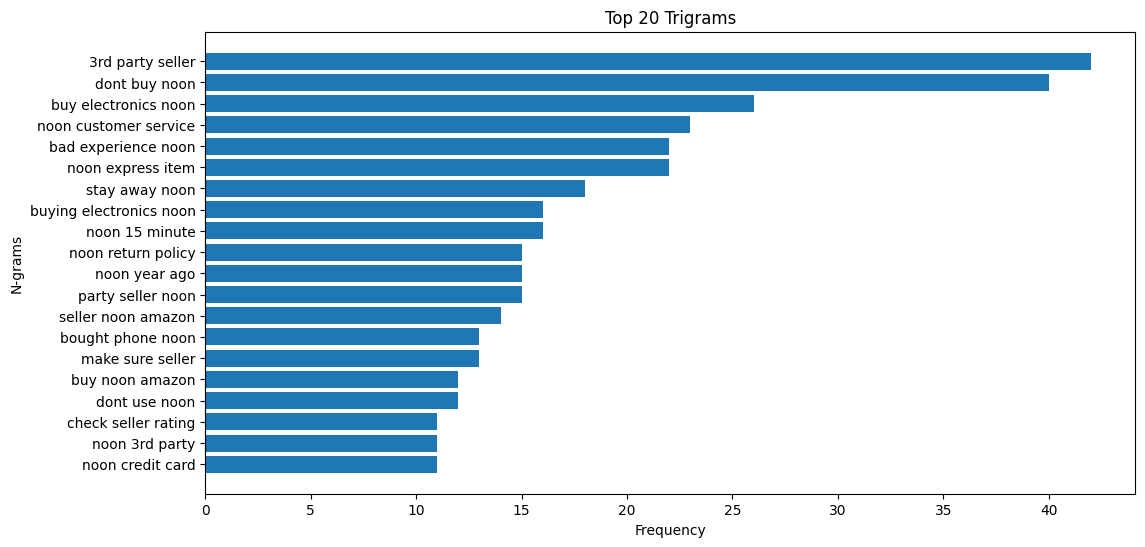

Top N-Grams:
      N-gram      Text  Frequency
0   Unigram      noon       4634
1   Unigram    amazon       1115
2   Unigram    seller        732
3   Unigram       buy        564
4   Unigram      dont        541
5   Unigram      item        524
6   Unigram   product        460
7   Unigram    bought        440
8   Unigram      like        429
9   Unigram       got        418
10  Unigram     order        417
11  Unigram      good        411
12  Unigram      time        407
13  Unigram    return        389
14  Unigram     issue        374
15  Unigram  customer        366
16  Unigram  delivery        362
17  Unigram     price        350
18  Unigram       day        342
19  Unigram     phone        331
N-Gram Analysis saved to N_Gram_Analysis.xlsx


In [32]:
# Load the dataset (Ensure 'processed_comment' column is present)
df = df.dropna(subset=['processed_comment'])  # Remove empty comments

# Function to visualize top N features
def plot_top_ngrams(ngram_counts, title):
    ngrams, frequencies = zip(*ngram_counts)
    plt.figure(figsize=(12, 6))
    plt.barh(ngrams[::-1], frequencies[::-1])
    plt.xlabel("Frequency")
    plt.ylabel("N-grams")
    plt.title(title)
    plt.show()

# **STEP 1: N-GRAM VS UNIGRAM COMPARISON**
vectorizer_uni = CountVectorizer(ngram_range=(1, 1), stop_words='english')
X_uni = vectorizer_uni.fit_transform(df['processed_comment'])
unigram_counts = Counter(dict(zip(vectorizer_uni.get_feature_names_out(), X_uni.toarray().sum(axis=0)))).most_common(20)

vectorizer_bi = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bi = vectorizer_bi.fit_transform(df['processed_comment'])
bigram_counts = Counter(dict(zip(vectorizer_bi.get_feature_names_out(), X_bi.toarray().sum(axis=0)))).most_common(20)

vectorizer_tri = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X_tri = vectorizer_tri.fit_transform(df['processed_comment'])
trigram_counts = Counter(dict(zip(vectorizer_tri.get_feature_names_out(), X_tri.toarray().sum(axis=0)))).most_common(20)

# **Visualization**
plot_top_ngrams(unigram_counts, "Top 20 Unigrams")
plot_top_ngrams(bigram_counts, "Top 20 Bigrams")
plot_top_ngrams(trigram_counts, "Top 20 Trigrams")

# Convert n-grams results to DataFrame for better visualization
ngram_df = pd.DataFrame({
    "N-gram": ["Unigram"] * 20 + ["Bigram"] * 20 + ["Trigram"] * 20,
    "Text": [n[0] for n in unigram_counts] + [n[0] for n in bigram_counts] + [n[0] for n in trigram_counts],
    "Frequency": [n[1] for n in unigram_counts] + [n[1] for n in bigram_counts] + [n[1] for n in trigram_counts]
})

# **Display & Save Results**
print("Top N-Grams:\n", ngram_df.head(20))
ngram_df.to_excel("N_Gram_Analysis.xlsx", index=False)
print("N-Gram Analysis saved to N_Gram_Analysis.xlsx")


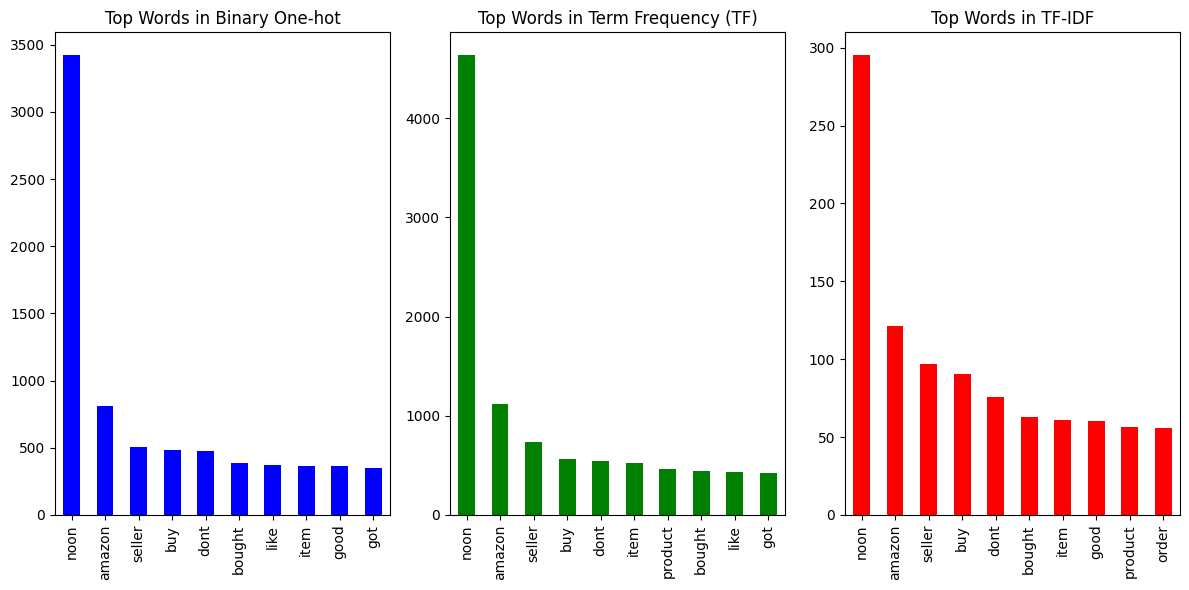

Text Representation Comparison:
      Word          Method   Value
0    noon  Binary One-hot  3421.0
1  amazon  Binary One-hot   811.0
2  seller  Binary One-hot   503.0
3     buy  Binary One-hot   484.0
4    dont  Binary One-hot   473.0
5  bought  Binary One-hot   385.0
6    like  Binary One-hot   370.0
7    item  Binary One-hot   365.0
8    good  Binary One-hot   364.0
9     got  Binary One-hot   351.0
Representation Comparison saved to Representation_Comparison.xlsx

TF-IDF is selected as the best representation method because:
1. It gives **higher importance to rare words** and reduces the impact of common words.
2. Unlike One-hot encoding, it retains frequency information without making the feature space too sparse.
3. Unlike raw term frequency (TF), TF-IDF adjusts for document-wide frequency, making it more useful in sentiment analysis.



In [33]:

# **STEP 2: TEXT REPRESENTATION COMPARISON**
vectorizer_binary = CountVectorizer(binary=True, stop_words='english')
X_binary = vectorizer_binary.fit_transform(df['processed_comment'])
binary_df = pd.DataFrame(X_binary.toarray(), columns=vectorizer_binary.get_feature_names_out())

vectorizer_tf = CountVectorizer(stop_words='english')
X_tf = vectorizer_tf.fit_transform(df['processed_comment'])
tf_df = pd.DataFrame(X_tf.toarray(), columns=vectorizer_tf.get_feature_names_out())

vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(df['processed_comment'])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

# Compare top words in each method
binary_top = binary_df.sum().sort_values(ascending=False).head(10)
tf_top = tf_df.sum().sort_values(ascending=False).head(10)
tfidf_top = tfidf_df.sum().sort_values(ascending=False).head(10)

# **Visualization**
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
binary_top.plot(kind='bar', color='blue')
plt.title("Top Words in Binary One-hot")

plt.subplot(1, 3, 2)
tf_top.plot(kind='bar', color='green')
plt.title("Top Words in Term Frequency (TF)")

plt.subplot(1, 3, 3)
tfidf_top.plot(kind='bar', color='red')
plt.title("Top Words in TF-IDF")

plt.tight_layout()
plt.show()

# Save Results
representation_df = pd.DataFrame({
    "Word": list(binary_top.index) + list(tf_top.index) + list(tfidf_top.index),
    "Method": ["Binary One-hot"] * 10 + ["Term Frequency"] * 10 + ["TF-IDF"] * 10,
    "Value": list(binary_top.values) + list(tf_top.values) + list(tfidf_top.values)
})

print("Text Representation Comparison:\n", representation_df.head(10))
representation_df.to_excel("Representation_Comparison.xlsx", index=False)
print("Representation Comparison saved to Representation_Comparison.xlsx")

# **Justification for TF-IDF**
selected_representation = "TF-IDF"
justification = """
TF-IDF is selected as the best representation method because:
1. It gives **higher importance to rare words** and reduces the impact of common words.
2. Unlike One-hot encoding, it retains frequency information without making the feature space too sparse.
3. Unlike raw term frequency (TF), TF-IDF adjusts for document-wide frequency, making it more useful in sentiment analysis.
"""
print(justification)

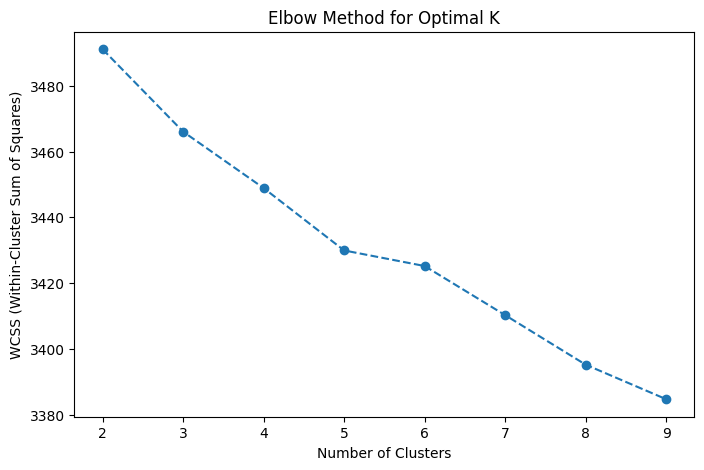

Silhouette Score for K-Means: -0.012507612872294639


In [36]:
# ========== K-Means Clustering ==========
# Finding the optimal number of clusters using the Elbow Method
wcss = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Applying K-Means with optimal K
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_tfidf)

# Silhouette Score
silhouette_kmeans = silhouette_score(X_tfidf, df['KMeans_Cluster'])
print(f'Silhouette Score for K-Means: {silhouette_kmeans}')



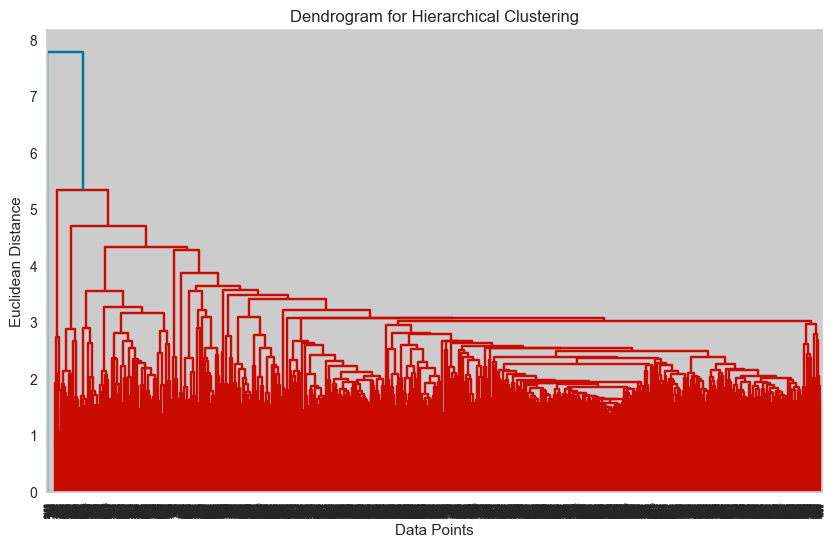

Silhouette Score for Hierarchical Clustering: -0.019190883280568168


In [40]:
# ========== Hierarchical Clustering ==========
plt.figure(figsize=(10, 6))
linked = linkage(X_tfidf.toarray(), method='ward')
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

# Applying Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
df['Hierarchical_Cluster'] = hierarchical.fit_predict(X_tfidf.toarray())

# Silhouette Score
silhouette_hierarchical = silhouette_score(X_tfidf, df['Hierarchical_Cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}')



In [41]:
# ========== DBSCAN Clustering ==========
dbscan = DBSCAN(eps=0.3, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_tfidf)

# Count clusters
dbscan_counts = Counter(df['DBSCAN_Cluster'])
print("DBSCAN Cluster Counts:", dbscan_counts)

# Silhouette Score for DBSCAN (Only if valid clusters exist)
dbscan_labels = df['DBSCAN_Cluster'].values
if len(set(dbscan_labels)) > 1:  # Ensure multiple clusters exist
    silhouette_dbscan = silhouette_score(X_tfidf, dbscan_labels)
    print(f'Silhouette Score for DBSCAN: {silhouette_dbscan}')
else:
    print("DBSCAN did not form valid clusters for silhouette evaluation.")



DBSCAN Cluster Counts: Counter({-1: 3542, 0: 35, 2: 9, 1: 6, 3: 6})
Silhouette Score for DBSCAN: -0.2664409663838411


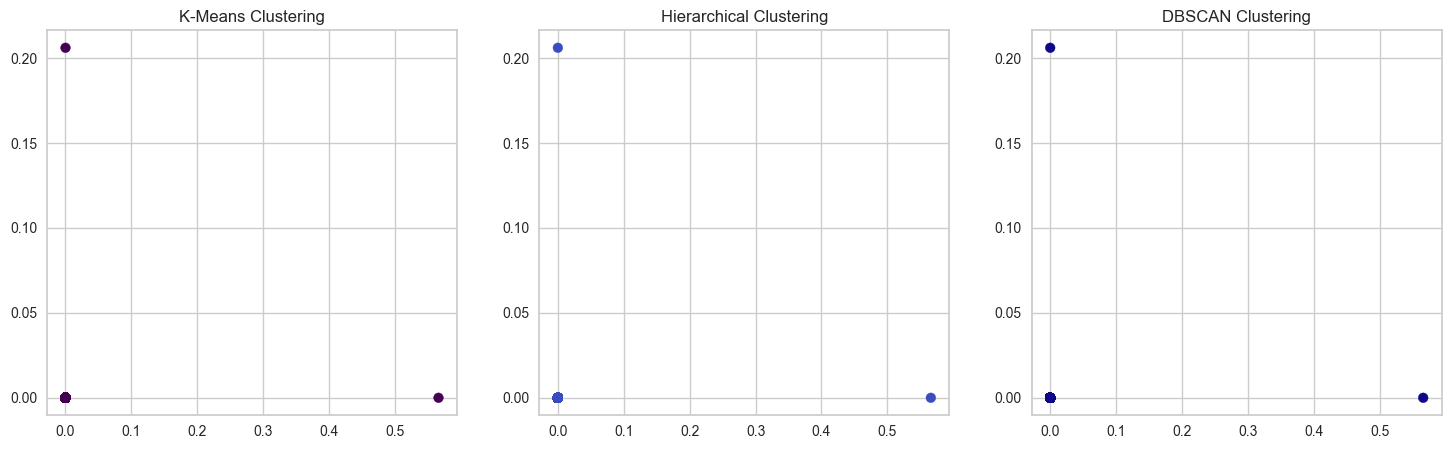

In [42]:
# ========== Clustering Visualization ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(X_tfidf.toarray()[:, 0], X_tfidf.toarray()[:, 1], c=df['KMeans_Cluster'], cmap='viridis')
axes[0].set_title("K-Means Clustering")

axes[1].scatter(X_tfidf.toarray()[:, 0], X_tfidf.toarray()[:, 1], c=df['Hierarchical_Cluster'], cmap='coolwarm')
axes[1].set_title("Hierarchical Clustering")

axes[2].scatter(X_tfidf.toarray()[:, 0], X_tfidf.toarray()[:, 1], c=df['DBSCAN_Cluster'], cmap='plasma')
axes[2].set_title("DBSCAN Clustering")
plt.show()



In [43]:
# ========== Conclusion: Best Clustering Algorithm ==========
print("\nComparing Clustering Performance:")
print(f"K-Means Silhouette Score: {silhouette_kmeans}")
print(f"Hierarchical Silhouette Score: {silhouette_hierarchical}")
print(f"DBSCAN Cluster Counts: {dbscan_counts}")

if silhouette_kmeans > silhouette_hierarchical:
    print("\nBest Clustering Algorithm: K-Means (Based on Silhouette Score)")
elif silhouette_hierarchical > silhouette_kmeans:
    print("\nBest Clustering Algorithm: Hierarchical Clustering (Based on Silhouette Score)")
else:
    print("\nBest Clustering Algorithm: Further analysis needed (Close Silhouette Scores)")



Comparing Clustering Performance:
K-Means Silhouette Score: -0.012507612872294639
Hierarchical Silhouette Score: -0.019190883280568168
DBSCAN Cluster Counts: Counter({-1: 3542, 0: 35, 2: 9, 1: 6, 3: 6})

Best Clustering Algorithm: K-Means (Based on Silhouette Score)


Binary Representation Shape: (3598, 7757)
Frequency Representation Shape: (3598, 7757)
TF-IDF Representation Shape: (3598, 7757)
Naive Bayes: Accuracy = 0.5736


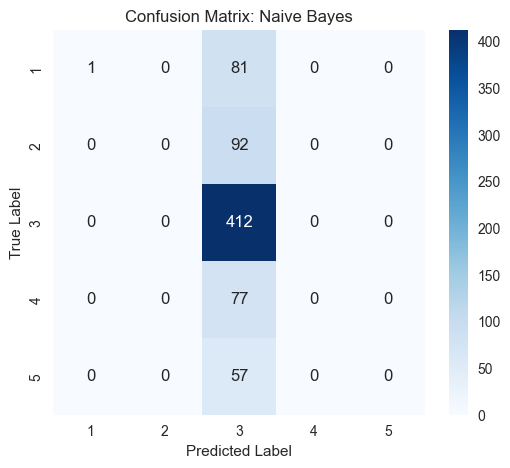


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           1     1.0000    0.0122    0.0241        82
           2     0.0000    0.0000    0.0000        92
           3     0.5730    1.0000    0.7286       412
           4     0.0000    0.0000    0.0000        77
           5     0.0000    0.0000    0.0000        57

    accuracy                         0.5736       720
   macro avg     0.3146    0.2024    0.1505       720
weighted avg     0.4418    0.5736    0.4196       720

KNN: Accuracy = 0.5750


/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

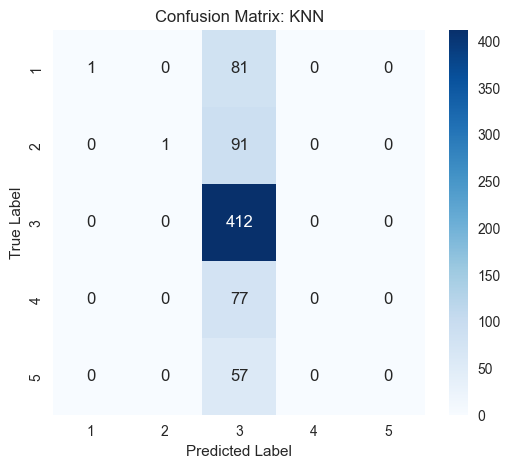

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


Classification Report for KNN:
               precision    recall  f1-score   support

           1     1.0000    0.0122    0.0241        82
           2     1.0000    0.0109    0.0215        92
           3     0.5738    1.0000    0.7292       412
           4     0.0000    0.0000    0.0000        77
           5     0.0000    0.0000    0.0000        57

    accuracy                         0.5750       720
   macro avg     0.5148    0.2046    0.1550       720
weighted avg     0.5700    0.5750    0.4228       720

SVM: Accuracy = 0.6319


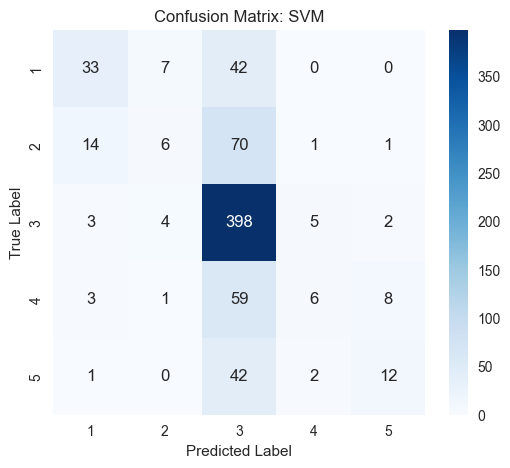


Classification Report for SVM:
               precision    recall  f1-score   support

           1     0.6111    0.4024    0.4853        82
           2     0.3333    0.0652    0.1091        92
           3     0.6514    0.9660    0.7781       412
           4     0.4286    0.0779    0.1319        77
           5     0.5217    0.2105    0.3000        57

    accuracy                         0.6319       720
   macro avg     0.5092    0.3444    0.3609       720
weighted avg     0.5721    0.6319    0.5523       720

Logistic Regression: Accuracy = 0.6125


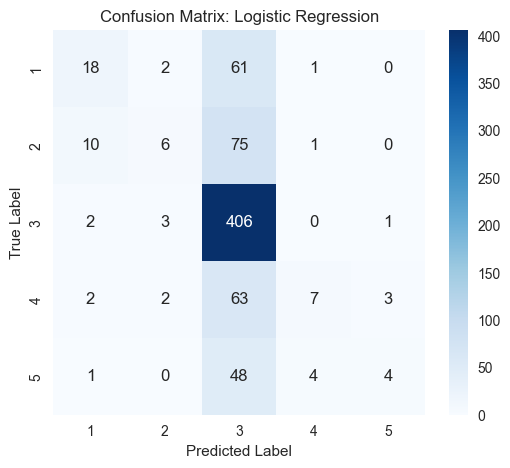


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           1     0.5455    0.2195    0.3130        82
           2     0.4615    0.0652    0.1143        92
           3     0.6217    0.9854    0.7624       412
           4     0.5385    0.0909    0.1556        77
           5     0.5000    0.0702    0.1231        57

    accuracy                         0.6125       720
   macro avg     0.5334    0.2863    0.2937       720
weighted avg     0.5740    0.6125    0.5129       720

Neural Network: Accuracy = 0.5403


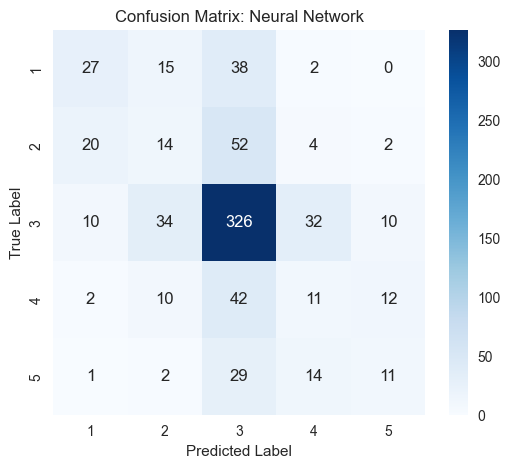


Classification Report for Neural Network:
               precision    recall  f1-score   support

           1     0.4500    0.3293    0.3803        82
           2     0.1867    0.1522    0.1677        92
           3     0.6694    0.7913    0.7253       412
           4     0.1746    0.1429    0.1571        77
           5     0.3143    0.1930    0.2391        57

    accuracy                         0.5403       720
   macro avg     0.3590    0.3217    0.3339       720
weighted avg     0.5017    0.5403    0.5155       720


🔹 Best Model: SVM with Accuracy: 0.6319


/var/folders/gx/9cn8k5x52gq_wpn2s2w4j2340000gn/T/ipykernel_60893/2454229691.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


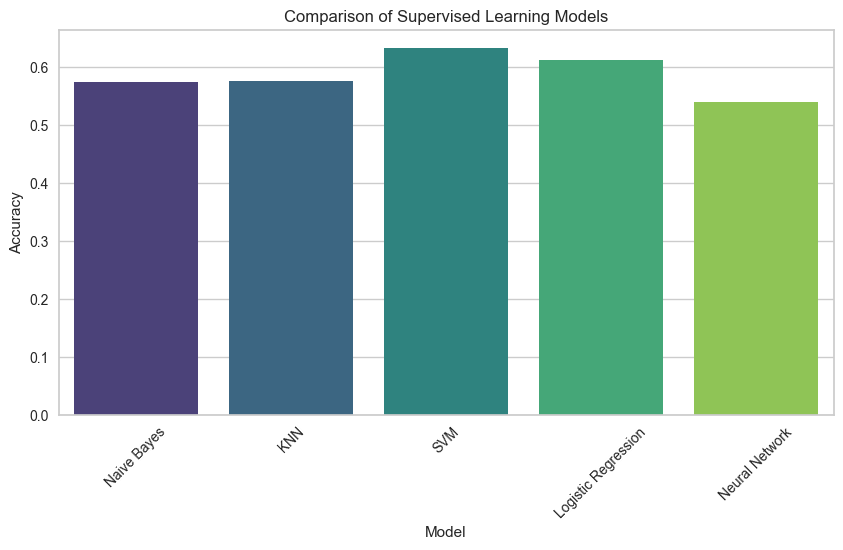

In [53]:
# -------------------------
# 🔹 Step 1: Vector Representation
# -------------------------
vectorizers = {
    "Binary": CountVectorizer(binary=True),
    "Frequency": CountVectorizer(),
    "TF-IDF": TfidfVectorizer()
}

X_train_dict, X_test_dict = {}, {}  # Store vectorized train/test data for all methods

for name, vectorizer in vectorizers.items():
    X = vectorizer.fit_transform(df['processed_comment'])  # Convert text into vectors
    X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment_Rating'], test_size=0.2, random_state=42)

    # Store vectorized data for later use
    X_train_dict[name] = X_train
    X_test_dict[name] = X_test

    print(f"{name} Representation Shape: {X.shape}")

# -------------------------
# 🔹 Step 2: Supervised Learning - Model Training
# -------------------------
models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

results = {}  # Store accuracy scores
best_vectorizer = "TF-IDF"  # Selecting the best representation method
X_train, X_test = X_train_dict[best_vectorizer], X_test_dict[best_vectorizer]

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Print Accuracy
    print(f"{name}: Accuracy = {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {name}:\n", classification_report(y_test, y_pred, digits=4))

# -------------------------
# 🔹 Step 3: Model Comparison
# -------------------------
best_model = max(results, key=results.get)
print(f"\n🔹 Best Model: {best_model} with Accuracy: {results[best_model]:.4f}")

# Bar Plot for Model Performance
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Supervised Learning Models")
plt.xticks(rotation=45)
plt.show()